In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, '..', 'sources'))
sys.path.insert(0, sources_path)

import matplotlib.pylab as plt
import numpy as np
from sc_fingerprint import *
from matplotlib import rc
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('text', usetex=False)

In [2]:
def make_error_boxes(ax, xdata, ydata, xerror, yerror, facecolor,
                     edgecolor='None', alpha=0.05, cmap=cm.winter,
                     pointsize=2):

    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
        rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
        errorboxes.append(rect)

    norm = mpl.colors.Normalize(vmin=np.min(facecolor), vmax=np.max(facecolor))
    m = cm.ScalarMappable(norm=norm, cmap=cmap)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, alpha=alpha, facecolor=m.to_rgba(facecolor))

    # Add collection to axes
    a = ax.add_collection(pc)

    # Plot errorbars
    sc = ax.scatter(xdata, ydata, s=pointsize, c=m.to_rgba(facecolor), alpha=1)
    
    return sc

## Load data

In [4]:
# load droplet-counts and chimera-counts
root = '/home/jupyter/data/10x/out/'
original_dataset_name = 'pbmc4k'
downsampled_dataset_name = 'pbmc4k_ss_rate_0.25'

original_suffix = 'alpha_0.0__beta_0.5__default_gene_filters__rc_1'
downsampled_suffix = 'alpha_0.0__beta_0.5__default_gene_filters__rc_1'

original_output_root = os.path.join(root, original_dataset_name + '__' + original_suffix)
downsampled_output_root = os.path.join(root, downsampled_dataset_name + '__' + downsampled_suffix)

# mutual genes between the two count matrices
enable_default_filters = False
original_gene_idx_list = np.load(os.path.join(original_output_root, 'gene_indices.npy'))
downsampled_gene_idx_list = np.load(os.path.join(downsampled_output_root, 'gene_indices.npy'))

if enable_default_filters:
    sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_ss_rate_0.25_sc_fingerprint.pkl'
    sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path).filter_genes()
    passing_gene_idx_set = set(sc_fingerprint.gene_idx_list)
else:
    passing_gene_idx_set = set(original_gene_idx_list).union(set(downsampled_gene_idx_list))

mutual_gene_idx_set = set(original_gene_idx_list).intersection(set(downsampled_gene_idx_list)).intersection(passing_gene_idx_set)
mutual_gene_idx_list = [gene_index for gene_index in original_gene_idx_list
                        if gene_index in mutual_gene_idx_set]

original_gene_idx_dict = {
    gene_index: order for order, gene_index in enumerate(original_gene_idx_list)}
original_gene_idx_lookup = [
    original_gene_idx_dict[gene_index] for gene_index in mutual_gene_idx_list]

downsampled_gene_idx_dict = {
    gene_index: order for order, gene_index in enumerate(downsampled_gene_idx_list)}
downsampled_gene_idx_lookup = [
    downsampled_gene_idx_dict[gene_index] for gene_index in mutual_gene_idx_list]


# load inferred counts
original_e_hi_map = np.load(os.path.join(original_output_root, 'e_hi_map.npy'))
original_e_hi_map = np.sum(original_e_hi_map[:, original_gene_idx_lookup], axis=0)
original_e_hi_std = np.load(os.path.join(original_output_root, 'e_hi_std.npy'))
original_e_hi_std = np.sqrt(np.sum(np.power(original_e_hi_std[:, original_gene_idx_lookup], 2), axis=0))
original_e_hi_mean = np.load(os.path.join(original_output_root, 'e_hi_mean.npy'))
original_e_hi_mean = np.sum(original_e_hi_mean[:, original_gene_idx_lookup], axis=0)

downsampled_e_hi_map = np.load(os.path.join(downsampled_output_root, 'e_hi_map.npy'))
downsampled_e_hi_map = np.sum(downsampled_e_hi_map[:, downsampled_gene_idx_lookup], axis=0)
downsampled_e_hi_std = np.load(os.path.join(original_output_root, 'e_hi_std.npy'))
downsampled_e_hi_std = np.sqrt(np.sum(np.power(downsampled_e_hi_std[:, original_gene_idx_lookup], 2), axis=0))
downsampled_e_hi_mean = np.load(os.path.join(downsampled_output_root, 'e_hi_mean.npy'))
downsampled_e_hi_mean = np.sum(downsampled_e_hi_mean[:, downsampled_gene_idx_lookup], axis=0)

In [5]:
std_fact = 3

original_e_hi_ci_upper = original_e_hi_map + std_fact * original_e_hi_std
original_e_hi_ci_lower = np.maximum(0, original_e_hi_map - std_fact * original_e_hi_std)
downsampled_e_hi_ci_upper = downsampled_e_hi_map + std_fact * downsampled_e_hi_std
downsampled_e_hi_ci_lower = np.maximum(0, downsampled_e_hi_map - std_fact * downsampled_e_hi_std)

In [6]:
# load fingerprint (downsampled)
sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_ss_rate_0.25_sc_fingerprint.pkl'
sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path)
sc_fingerprint_datastore = SingleCellFingerprintDataStore(
    sc_fingerprint, gene_idx_list=mutual_gene_idx_list)
downsampled_raw_counts = np.sum(sc_fingerprint_datastore.obs_expr_matrix, axis=0)

# load fingerprint (original)
sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_sc_fingerprint.pkl'
sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path)
sc_fingerprint_datastore = SingleCellFingerprintDataStore(
    sc_fingerprint, gene_idx_list=mutual_gene_idx_list)
original_raw_counts = np.sum(sc_fingerprint_datastore.obs_expr_matrix, axis=0)

Some genes in the provided fingerprint have zero expression!
Some genes in the provided fingerprint have zero expression!


### Total gene expression

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


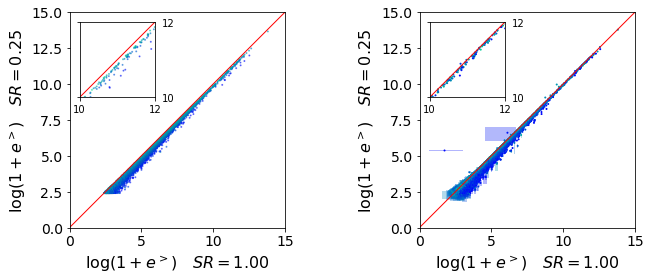

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
cmap = plt.cm.winter
alpha = 0.5
markersize = 1
_min, _max = np.min(downsampled_raw_counts), np.max(original_raw_counts)

ax = axs[0]
axins = inset_axes(ax, width="35%", height="35%", loc=2, borderpad=1)
for a in [ax, axins]:
    a.scatter(np.log1p(original_raw_counts), np.log1p(downsampled_raw_counts),
              c=sc_fingerprint_datastore.empirical_fsd_mu_hi,
              s=markersize, alpha=alpha, cmap=cmap)
ax.plot([0, _max], [0, _max], '-', color='red', lw=1)
ax.set_xlim((0, 15))
ax.set_ylim((0, 15))
ax.set_xlabel(r'$\log(1+e^>)\quad SR=1.00$', fontsize=16)
ax.set_ylabel(r'$\log(1+e^>)\quad SR=0.25$', fontsize=16)
ax.set_aspect('equal')

axins.plot([0, _max], [0, _max], '-', color='red', lw=1)
axins.set_xlim((10, 12))
axins.set_ylim((10, 12))
ticks = [10, 12]
axins.set_xticks(ticks)
axins.set_yticks(ticks)
axins.set_xticklabels(ticks, fontsize=10)
axins.set_yticklabels(ticks, fontsize=10)
axins.tick_params(labelleft=False, labelright=True, labelbottom=True)




ax = axs[1]
axins = inset_axes(ax, width="35%", height="35%", loc=2, borderpad=1)

# for a in [ax, axins]:
#     a.scatter(np.log1p(original_e_hi_mean), np.log1p(downsampled_e_hi_mean),
#               c=sc_fingerprint_datastore.empirical_fsd_mu_hi,
#               s=markersize, alpha=alpha, cmap=cmap)

for _ax in [ax, axins]:
    sc = make_error_boxes(
        _ax,
        np.log1p(original_e_hi_mean),
        np.log1p(downsampled_e_hi_mean),
        np.vstack((np.log1p(original_e_hi_map) - np.log1p(original_e_hi_ci_lower),
                   np.log1p(original_e_hi_ci_upper) - np.log1p(original_e_hi_map))),
        np.vstack((np.log1p(downsampled_e_hi_map) - np.log1p(downsampled_e_hi_ci_lower),
                   np.log1p(downsampled_e_hi_ci_upper) - np.log1p(downsampled_e_hi_map))),
        sc_fingerprint_datastore.empirical_fsd_mu_hi,
        alpha=0.3, pointsize=markersize)


axins.plot([0, _max], [0, _max], '-', color='red', lw=1)
axins.set_xlim((10, 12))
axins.set_ylim((10, 12))
ticks = [10, 12]
axins.set_xticks(ticks)
axins.set_yticks(ticks)
axins.set_xticklabels(ticks, fontsize=10)
axins.set_yticklabels(ticks, fontsize=10)
axins.tick_params(labelleft=False, labelright=True, labelbottom=True)


# cbar = plt.colorbar(sc)
# cbar.set_label(r'$\mu^>_\mathrm{emp.}$')

ax.plot([0, _max], [0, _max], '-', color='red', lw=1)
ax.set_xlim((0, 15))
ax.set_ylim((0, 15))
ax.set_xlabel(r'$\log(1+e^>)\quad SR=1.00$', fontsize=16)
ax.set_ylabel(r'$\log(1+e^>)\quad SR=0.25$', fontsize=16)
ax.set_aspect('equal')

plt.tight_layout()

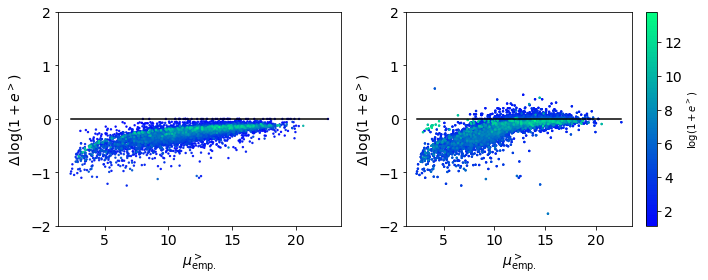

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
cmap = plt.cm.winter
alpha = 0.9
markersize = 2

ax = axs[0]
delta_mean = np.log1p(downsampled_raw_counts) - np.log1p(original_raw_counts)
sc = ax.scatter(sc_fingerprint_datastore.empirical_fsd_mu_hi[::-1],
                delta_mean[::-1],
                c=np.log1p(original_raw_counts)[::-1],
                s=markersize, alpha=alpha, cmap=cmap)

ax.set_ylim((-2, 2))
_min, _max = (np.min(sc_fingerprint_datastore.empirical_fsd_mu_hi), 
              np.max(sc_fingerprint_datastore.empirical_fsd_mu_hi))
ax.plot([_min, _max], [0.0, 0.0], '-', color='black', alpha=1)
ax.set_ylabel(r'$\Delta\,\log(1+e^>)$', fontsize=14)
ax.set_xlabel(r'$\mu^>_\mathrm{emp.}$', fontsize=14)

ax = axs[1]
delta_mean = np.log1p(downsampled_e_hi_map) - np.log1p(original_e_hi_map)
delta_var = (np.power(downsampled_e_hi_std, 2) / np.power(1 + downsampled_e_hi_map, 2) +
             np.power(original_e_hi_std, 2) / np.power(1 + original_e_hi_map, 2))
delta_std = np.sqrt(delta_var)

sc = ax.scatter(sc_fingerprint_datastore.empirical_fsd_mu_hi[::-1],
                delta_mean[::-1],
                c=np.log1p(original_e_hi_map)[::-1],
                s=markersize, alpha=alpha, cmap=cmap)

n_genes = sc_fingerprint_datastore.empirical_fsd_mu_hi.size
make_error_boxes(
    ax,
    sc_fingerprint_datastore.empirical_fsd_mu_hi[::-1],
    delta_mean[::-1],
    0 * np.ones((2, n_genes)),
    3 * np.vstack((delta_std[::-1], delta_std[::-1])),
    np.log1p(original_e_hi_map)[::-1],
    alpha=0.2, pointsize=markersize)


ax.set_ylim((-2, 2))
_min, _max = (np.min(sc_fingerprint_datastore.empirical_fsd_mu_hi), 
              np.max(sc_fingerprint_datastore.empirical_fsd_mu_hi))
ax.plot([_min, _max], [0.0, 0.0], '-', color='black', alpha=1)
ax.set_ylabel(r'$\Delta\,\log(1+e^>)$', fontsize=14)
ax.set_xlabel(r'$\mu^>_\mathrm{emp.}$', fontsize=14)

cbar = plt.colorbar(sc)
cbar.set_label(r'$\log(1 + e^>)$')

plt.tight_layout()

In [2]:
sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_sc_fingerprint.pkl'
sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path)

In [25]:
csr_fingerprint_list = list(map(sc_fingerprint.csr_fingerprint_dict.get, sc_fingerprint.barcode_list))